In [52]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss

# data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
train = pd.read_csv(r'/kaggle/input/crime-multiclass-classification/train.csv')
test = pd.read_csv(r'/kaggle/input/crime-multiclass-classification/test.csv')
sample = pd.read_csv(r'/kaggle/input/crime-multiclass-classification/sampleSubmission.csv')

In [5]:
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [6]:
test.head(2)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432


In [7]:
sample.head(4)

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Data Cleaning and Exploration

### Train Set

In [8]:
train.info() #-there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [9]:
train.describe(include = 'all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878049,878049,878049,878049,878049,878049,878049,878049.000000,878049.000000
unique,389257,39,879,7,10,17,23228,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174900,60022,133734,157182,526790,26533,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422616,37.771020
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030354,0.456893
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.416420,37.775421
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.406959,37.784369


In [10]:
train['Dates'].head() #-we would perform feature engineering on this to separate it year, month, etc

0    2015-05-13 23:53:00
1    2015-05-13 23:53:00
2    2015-05-13 23:33:00
3    2015-05-13 23:30:00
4    2015-05-13 23:30:00
Name: Dates, dtype: object

In [11]:
train['PdDistrict'].value_counts()

PdDistrict
SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: count, dtype: int64

In [12]:
# pdgroup = train.groupby('pdDistrict')

In [13]:
train['Resolution'].value_counts()

Resolution
NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: count, dtype: int64

In [14]:
print(train['Category'].nunique())
train['Category'].value_counts() #- target column that will be used for multilabel classification

39


Category
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQ

#### Data Type Conversion and Feature Engineering on Train and Test Set

In [15]:
#Convert Dates column to datetime format
#Train set
train['Dates'] = pd.to_datetime(train['Dates'])

#Test set
test['Dates'] = pd.to_datetime(test['Dates'])

##### Feature Engineering

In [16]:
#Extracting features from Date
#Train set
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['DayOfMonth'] = train['Dates'].dt.day
train['Hour'] = train['Dates'].dt.hour
train['Minute'] = train['Dates'].dt.minute
train['Quarter'] = train['Dates'].dt.quarter

#Test set
test['Year'] = train['Dates'].dt.year
test['Month'] = test['Dates'].dt.month
test['DayofMonth'] = test['Dates'].dt.day
test['Hour'] = test['Dates'].dt.hour
test['Minute'] = test['Dates'].dt.minute
test['Quarter'] = test['Dates'].dt.quarter

In [17]:
test.dropna(inplace = True)

In [18]:
np.unique(test['Year'])

array([2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015.])

In [19]:
print(train.shape)
print(test.shape)

(878049, 15)
(878049, 13)


In [20]:
# Create KMeans clusters based on geographical coordinates 
num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(train[['X', 'Y']]) 

train['Cluster'] = kmeans.predict(train[['X', 'Y']]) 
test['Cluster'] = kmeans.predict(test[['X', 'Y']]) 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
# Feature Renaming for easy understanding
train.rename(columns={'X': 'Longitude', 'Y': 'Latitude'}, inplace=True)
test.rename(columns={'X': 'Longitude', 'Y': 'Latitude'}, inplace=True)

### EDA

#### BAsic Visualizations to get a basic understanding of the data

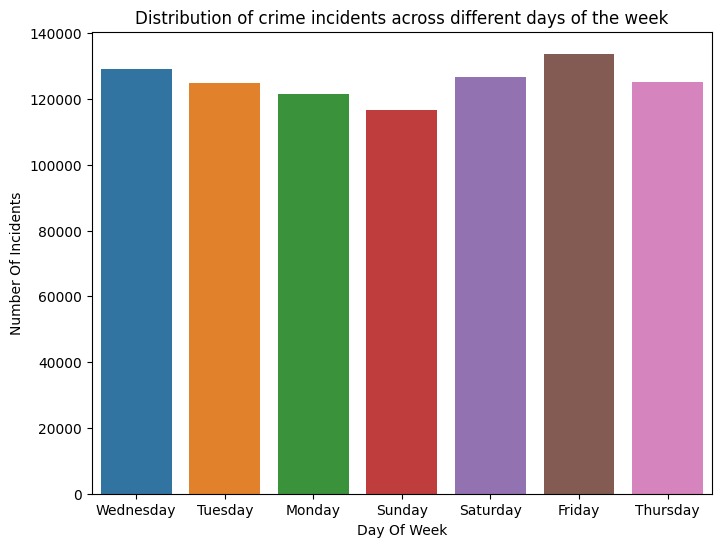

In [22]:
# What is the distribution of crime incidents across different days of the week?

plt.figure(figsize=(8,6))
sns.countplot(x='DayOfWeek', data=train)
plt.xlabel('Day Of Week')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different days of the week')
plt.show()

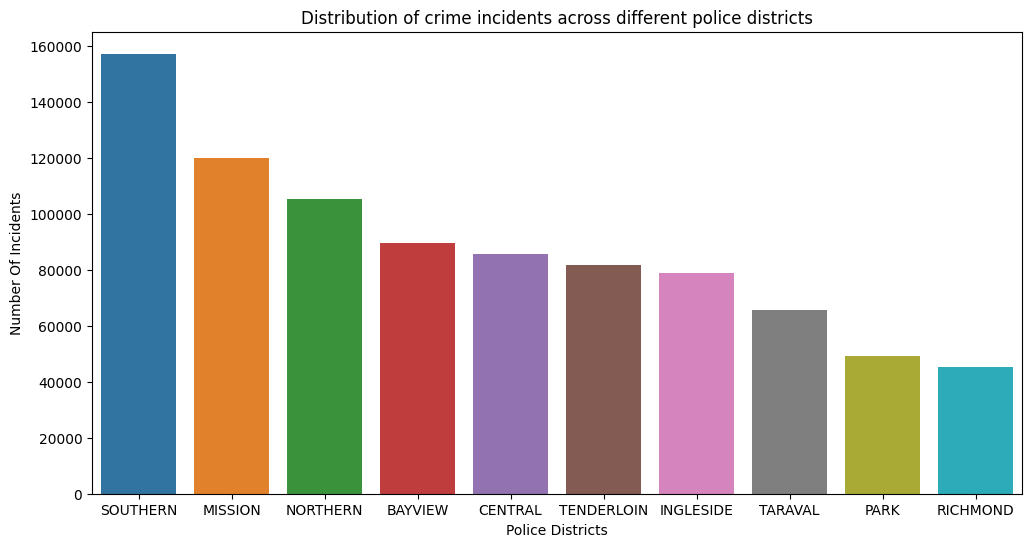

In [23]:
# How does crime rate vary by police district?

plt.figure(figsize=(12,6))
sns.countplot(x='PdDistrict', data = train, order = train['PdDistrict'].value_counts().index)
plt.xlabel('Police Districts')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different police districts')
plt.show()

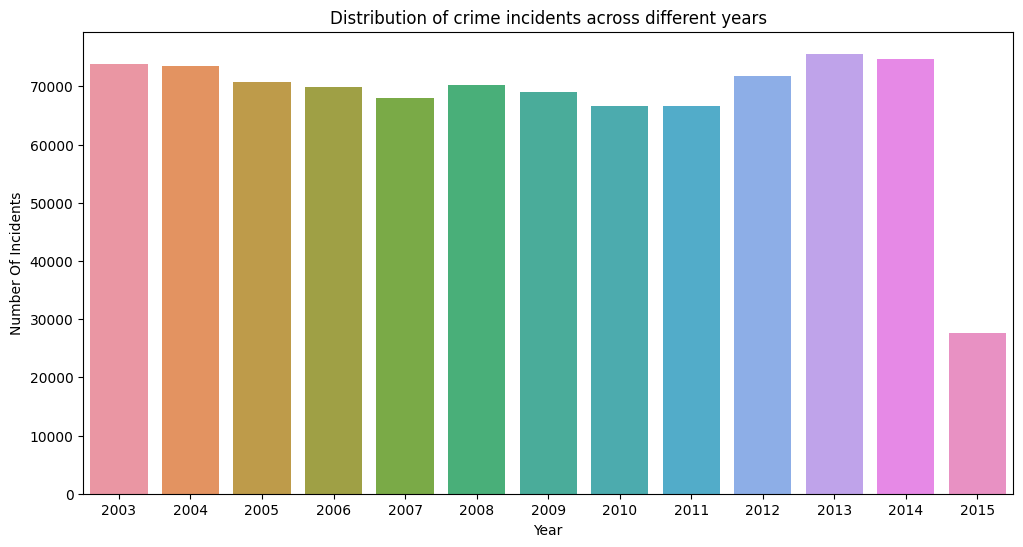

In [24]:
# What is the trend of crime incidents over the year?

plt.figure(figsize=(12,6))
sns.countplot(x='Year', data = train)
plt.xlabel('Year')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different years')
plt.show()

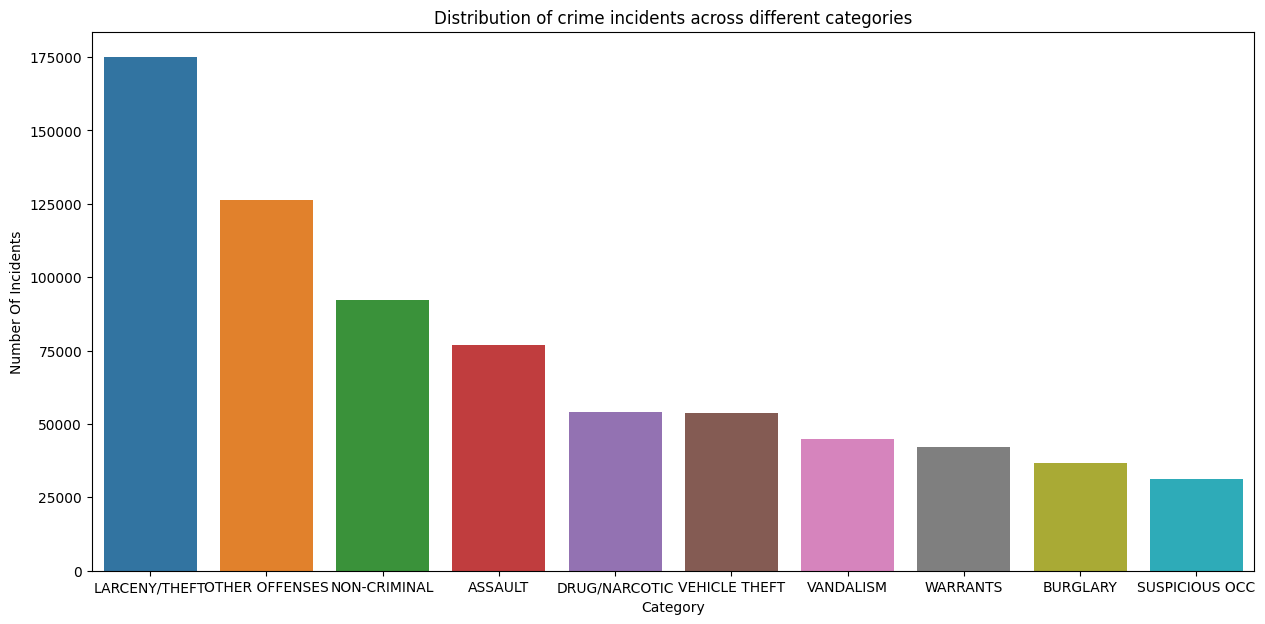

In [25]:
#How does the distribution of incidents vary by crime category

plt.figure(figsize=(15,7))
sns.countplot(x='Category', data = train, order = train['Category'].value_counts().iloc[:10].index)
plt.xlabel('Category')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different categories')
plt.show()

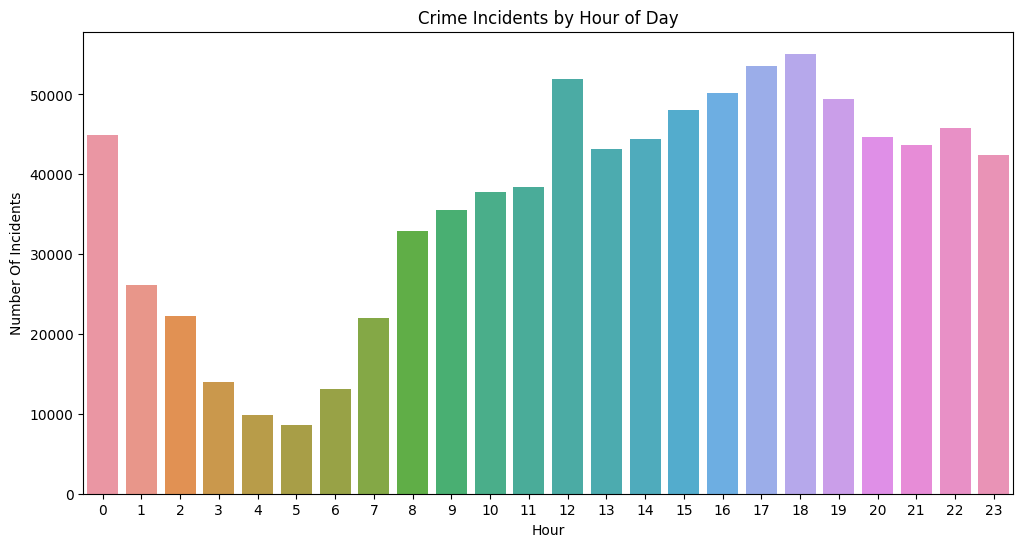

In [26]:
# Are there any patterns in crime incidents based on hours of the day?

plt.figure(figsize=(12,6))
sns.countplot(x='Hour',data = train)
plt.xlabel('Hour')
plt.ylabel('Number Of Incidents')
plt.title('Crime Incidents by Hour of Day')
plt.show()

#### Geospatial Visualtizations

import folium

# Create a map centered around San Francisco
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Add markers for crime incidents
for index, row in train.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(map_sf)

# Display the map
map_sf.save('crime_map.html')  # Save the map as an HTML file


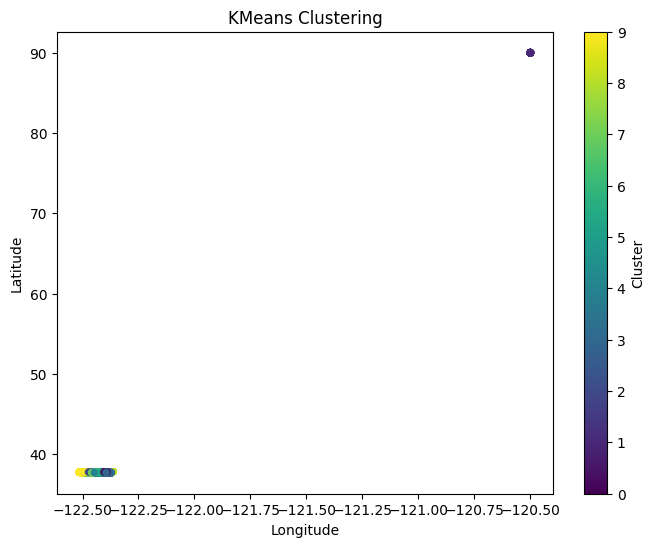

In [27]:
# Scatter plot to show different clusters 

plt.figure(figsize=(8, 6))
plt.scatter(train['Longitude'], train['Latitude'], c=train['Cluster'], cmap='viridis', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering')
plt.colorbar(label='Cluster')
plt.show()


# Data preprocessing

In [28]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,30,2,6


In [29]:
# converting all the input into lower case
def lower(df, features):
    for feature in features:
        df[feature] = df[feature].apply(lambda x: x.lower())

In [30]:
lower(train, ['Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address'])
lower(train, ['Category'])
lower(test, ['DayOfWeek', 'PdDistrict', 'Address'])
train.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,warrants,warrant arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",vanness av / greenwich st,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,northern,none,1500 block of lombard st,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,park,none,100 block of broderick st,-122.438738,37.771541,2015,5,13,23,30,2,6


In [31]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,Longitude,Latitude,Year,Month,DayofMonth,Hour,Minute,Quarter,Cluster
0,0,2015-05-10 23:59:00,sunday,bayview,2000 block of thomas av,-122.399588,37.735051,2015.0,5,10,23,59,2,3
1,1,2015-05-10 23:51:00,sunday,bayview,3rd st / revere av,-122.391523,37.732432,2015.0,5,10,23,51,2,3
2,2,2015-05-10 23:50:00,sunday,northern,2000 block of gough st,-122.426002,37.792212,2015.0,5,10,23,50,2,6
3,3,2015-05-10 23:45:00,sunday,ingleside,4700 block of mission st,-122.437394,37.721412,2015.0,5,10,23,45,2,4
4,4,2015-05-10 23:45:00,sunday,ingleside,4700 block of mission st,-122.437394,37.721412,2015.0,5,10,23,45,2,4


In [32]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,warrants,warrant arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",vanness av / greenwich st,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,northern,none,1500 block of lombard st,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,park,none,100 block of broderick st,-122.438738,37.771541,2015,5,13,23,30,2,6


In [33]:
test_id = test['Id']

In [34]:
le = LabelEncoder()
for feature in ['DayOfWeek', 'PdDistrict', 'Address', 'Category']:
    train[feature] = le.fit_transform(train[feature])

train

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,37,warrant arrest,6,4,"arrest, booked",19790,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,21,traffic violation arrest,6,4,"arrest, booked",19790,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,21,traffic violation arrest,6,4,"arrest, booked",22697,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,16,grand theft from locked auto,6,4,none,4266,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,16,grand theft from locked auto,6,5,none,1843,-122.438738,37.771541,2015,5,13,23,30,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,25,robbery on the street with a gun,1,8,none,15816,-122.459033,37.714056,2003,1,6,0,15,1,7
878045,2003-01-06 00:01:00,16,grand theft from locked auto,1,2,none,11491,-122.447364,37.731948,2003,1,6,0,1,1,4
878046,2003-01-06 00:01:00,16,grand theft from locked auto,1,7,none,11315,-122.403390,37.780266,2003,1,6,0,1,1,0
878047,2003-01-06 00:01:00,35,"malicious mischief, vandalism of vehicles",1,7,none,22308,-122.390531,37.780607,2003,1,6,0,1,1,0


In [35]:
X = train.drop(['Dates', 'Cluster', 'Descript', 'Resolution', 'Category'], axis = 1)
y = train.Category
test.drop(['Dates', 'Cluster'], axis = 1, inplace = True)

In [36]:
for feature in ['DayOfWeek', 'PdDistrict', 'Address']:
    test[feature] = le.fit_transform(test[feature]) 

In [37]:
test

,Id,DayOfWeek,PdDistrict,Address,Longitude,Latitude,Year,Month,DayofMonth,Hour,Minute,Quarter
0,0,3,0,6403,-122.399588,37.735051,2015.0,5,10,23,59,2
1,1,3,0,9739,-122.391523,37.732432,2015.0,5,10,23,51,2
2,2,3,4,6332,-122.426002,37.792212,2015.0,5,10,23,50,2
3,3,3,2,10627,-122.437394,37.721412,2015.0,5,10,23,45,2
4,4,3,2,10627,-122.437394,37.721412,2015.0,5,10,23,45,2
...,...,...,...,...,...,...,...,...,...,...,...,...
878044,878044,6,4,14582,-122.436275,37.800813,2003.0,1,29,21,0,1
878045,878045,6,4,7219,-122.434667,37.788745,2003.0,1,29,21,0,1
878046,878046,6,4,14582,-122.436275,37.800813,2003.0,1,29,21,0,1
878047,878047,6,1,21227,-122.401857,37.796626,2003.0,1,29,21,0,1


In [38]:
np.unique(test['Year'])

array([2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015.])

In [39]:
test.drop('Id', axis = 1, inplace = True)

In [40]:
X_copy, test_copy = X.copy(), test.copy()

# Model building

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 4)

In [42]:
X_train

,DayOfWeek,PdDistrict,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter
313228,2,9,10939,-122.415414,37.784477,2011,1,15,15,30,1
490198,3,4,16615,-122.418810,37.781235,2008,6,15,13,45,2
75483,6,3,9073,-122.419308,37.755456,2014,5,14,19,0,2
98169,4,4,9114,-122.439368,37.799932,2014,1,23,13,0,1
288535,4,8,20795,-122.467376,37.749026,2011,6,2,15,55,2
...,...,...,...,...,...,...,...,...,...,...,...
639432,6,7,1731,-122.408467,37.780701,2006,4,19,10,0,2
653672,5,3,2901,-122.406539,37.756486,2006,2,7,0,1,1
120705,6,2,19287,-122.419124,37.746776,2013,10,2,23,20,4
377541,1,2,10102,-122.434266,37.721236,2010,2,8,12,0,1


In [43]:
test

,DayOfWeek,PdDistrict,Address,Longitude,Latitude,Year,Month,DayofMonth,Hour,Minute,Quarter
0,3,0,6403,-122.399588,37.735051,2015.0,5,10,23,59,2
1,3,0,9739,-122.391523,37.732432,2015.0,5,10,23,51,2
2,3,4,6332,-122.426002,37.792212,2015.0,5,10,23,50,2
3,3,2,10627,-122.437394,37.721412,2015.0,5,10,23,45,2
4,3,2,10627,-122.437394,37.721412,2015.0,5,10,23,45,2
...,...,...,...,...,...,...,...,...,...,...,...
878044,6,4,14582,-122.436275,37.800813,2003.0,1,29,21,0,1
878045,6,4,7219,-122.434667,37.788745,2003.0,1,29,21,0,1
878046,6,4,14582,-122.436275,37.800813,2003.0,1,29,21,0,1
878047,6,1,21227,-122.401857,37.796626,2003.0,1,29,21,0,1


In [44]:
d = pd.DataFrame(y_test)
d.value_counts()

Category
16          34735
21          25202
20          18472
1           15397
36          10829
7           10798
35           8973
37           8547
4            7329
32           6311
19           5221
25           4586
13           3272
12           2086
27           2009
38           1701
23           1526
34           1499
30            943
8             890
5             887
28            844
24            659
6             450
15            449
17            384
26            373
0             294
18            271
9             239
31            107
11             81
2              80
3              63
10             48
29             25
14             24
22              5
33              1
Name: count, dtype: int64

In [45]:
cat_model = CatBoostClassifier()

In [46]:
cat_model.fit(X_train, y_train)

Learning rate set to 0.110535
0:	learn: 3.2670324	total: 3.7s	remaining: 1h 1m 32s
1:	learn: 3.1034686	total: 7.1s	remaining: 59m 3s
2:	learn: 2.9872841	total: 10.5s	remaining: 57m 57s
3:	learn: 2.8997330	total: 13.9s	remaining: 57m 33s
4:	learn: 2.8304484	total: 17.2s	remaining: 57m 10s
5:	learn: 2.7677524	total: 20.6s	remaining: 56m 50s
6:	learn: 2.7172298	total: 24s	remaining: 56m 42s
7:	learn: 2.6759237	total: 27.8s	remaining: 57m 22s
8:	learn: 2.6424654	total: 31.1s	remaining: 57m 6s
9:	learn: 2.6144738	total: 34.5s	remaining: 56m 59s
10:	learn: 2.5912285	total: 37.9s	remaining: 56m 48s
11:	learn: 2.5698015	total: 41.3s	remaining: 56m 37s
12:	learn: 2.5511655	total: 44.7s	remaining: 56m 31s
13:	learn: 2.5351655	total: 48.1s	remaining: 56m 24s
14:	learn: 2.5210733	total: 51.4s	remaining: 56m 15s
15:	learn: 2.5091139	total: 54.8s	remaining: 56m 11s
16:	learn: 2.4986723	total: 58.3s	remaining: 56m 12s
17:	learn: 2.4894455	total: 1m 1s	remaining: 56m 8s
18:	learn: 2.4816318	total: 1m 

In [55]:
pred_pro = cat_model.predict_proba(X_test)
pred = cat_model.predict(X_test)

In [56]:
y_test.value_counts()

Category
16    34735
21    25202
20    18472
1     15397
36    10829
7     10798
35     8973
37     8547
4      7329
32     6311
19     5221
25     4586
13     3272
12     2086
27     2009
38     1701
23     1526
34     1499
30      943
8       890
5       887
28      844
24      659
6       450
15      449
17      384
26      373
0       294
18      271
9       239
31      107
11       81
2        80
3        63
10       48
29       25
14       24
22        5
33        1
Name: count, dtype: int64

In [63]:
cat_prediction = pd.DataFrame(pred_pro)
cat_prediction.to_csv(r'/kaggle/input/crime-multiclass-classification/catsub.csv')

NameError: name 'pred_pro' is not defined

In [58]:
accuracy_score(y_test, pred)

0.3143328967598656

In [59]:
print(log_loss(y_test, pred_pro))

2.2569907908327616


In [60]:
y

0         37
1         21
2         21
3         16
4         16
          ..
878044    25
878045    16
878046    16
878047    35
878048    12
Name: Category, Length: 878049, dtype: int64

In [47]:
rfmodel = RandomForestClassifier(
                                n_estimators=60,
                                max_depth=32,
                                random_state=1)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, n_estimators=60, random_state=1)

In [57]:
rf_pred = rfmodel.predict(X_test)
print(accuracy_score(y_test, rf_pred))
print(log_loss(y_test, rfmodel.predict_proba(X_test)))

0.3219235806616935
5.264904020986897
0.3219235806616935


In [67]:
rf_prediction = pd.DataFrame(rfmodel.predict_proba(X_test))
rf_prediction.to_csv('/kaggle/working/rfsub.csv', index= False)

In [58]:
from sklearn.linear_model import LogisticRegressionCV

In [60]:
lrmodel = LogisticRegressionCV(max_iter= 5000, random_state = 4)
lrmodel.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
lr_pred = lrmodel.predict(X_test)
print(accuracy_score(y_test, lr_pred))
print(log_loss(y_test, lrmodel.predict_proba(X_test)))
print(lrmodel.score(X_test, y_test))

In [ ]:
lr_prediction = pd.DataFrame(lrmodel.predict_proba(X_test))
lr_prediction.to_csv(r'/kaggle/input/crime-multiclass-classification/lrsub.csv')

to balance the target in the dataset use stratify in the train test split 

or 
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
